## 12. naloga: Strojno uˇcenje (machine learning)

Naloga: Na spletni uˇcilnici je na voljo material (koda, vzorci) za loˇcevanje dogodkov Higgsovega bozona
od ostalih procesov ozadja. V naboru simuliranih dogodkov je 18 karakteristik (zveznih kinematiˇcnih
lastnosti), katerih vsaka posamezno zelo slabo loˇci ’signal’ od ozadja, z uporabo BDT ali (D)NN,
pa lahko tu doseˇzemo zelo dober uspeh. Na predavanjih smo si ogledali glavne aspekte pomembne
pri implementaciji ML, kot so uporaba ustreznih spremenljivk (GIGO), uˇcenje in prekomerno uˇcenje
(training/overtraining), vrednotenje uspeha metode kot razmerje med uˇcinkovitostjo (efficiency) in
ˇcistostjo (precision) vzorca (Receiver Operating Characteristic, ROC). Doloˇci uspeˇsnost obeh metod
(in nariˇsi ROC) za nekaj tipiˇcih konfiguracij BDT in DNN, pri ˇcemer:
• Studiraj vpliv uporabljenih vhodnih spremenljivk - kaj, ˇce vzamemo le nekatere? ˇ
• Studiraj BDT in NN in vrednoti uspeˇsnost razliˇcnih nastavitev, ˇce spreminjaˇs nekaj konfigu- ˇ
racijskih parametrov (npr. ˇstevilo perceptronov in plasti nevronskih mreˇz pri DNN in ˇstevilo
dreves pri BDT).

Dodatna Naloga: Implementiraj distribucije iz ‘playground’ zgleda v BDT (lahko tudi RandomForests)
in DNN, te distribucije so na voljo v vseh popularnih ML paketih (npr. Scikit...).

In [64]:
# !pip install wget
# !pip install catboost

In [65]:
# import os,sys

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append("/content/drive/My Drive/Collab/collab_v1")
# %cd "/content/drive/My Drive/Collab/collab_v1"

In [66]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import datasets
import time


from catboost import CatBoostClassifier, Pool
# from google.colab import output
# output.enable_custom_widget_manager()

Tu so potrebni dodatni fili iz spletnih učilnic!

In [67]:
#some plotting routines
import plotting

# data processing
import data_higgs as dh


In [68]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(SEED_VALUE)

In [69]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data
    #prepare the data => normalizations !

    # split
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only

    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling
    data_x = (data_x - mu)/s

    #scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    #data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [70]:
def main(nepoch=100):
    # Training progress and eval results are shown as logging.INFO; so enables it.

    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))


    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    
    # ready the data for Catboost
    pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
    pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())

    
    # CatBoost parameters
    eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
    task_type = 'CPU'  # if GPU else 'CPU'
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'
    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )

    
    #now train the model
    bdt.fit(
            pool_train,
            #early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=True # works when called through Ipython/jupyter
        )
    print("HERE0!")

    #print()
    print("HERE!")
    #plot & print results like ROC and score distribution etc...
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    print("HERE2!")
    print("score shape {}",y_score.shape)
    print("HERE3!")
    plotting.plot_roc(y_val,y_score)
    print("HERE4!")
    plotting.plot_score(y_val,y_score)
    #plt.savefig("4.png")
    fake, true, _ = sklearn.metrics.roc_curve(y_val,y_score)
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))
    print("logloss score: {}".format(sklearn.metrics.log_loss(y_val,y_score)))
    print("rmse score: {}".format(sklearn.metrics.mean_squared_error(y_val,y_score)))
    print("rmse score: {}".format(sklearn.metrics.mean_squared_error(y_score, y_val)))
    #print("eval score: {}".format(bdt.evaluate(x_val,y_val)))
    #print("logloss score: {}".format(sklearn.metrics.accuracy_score(y_val,y_score)))

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


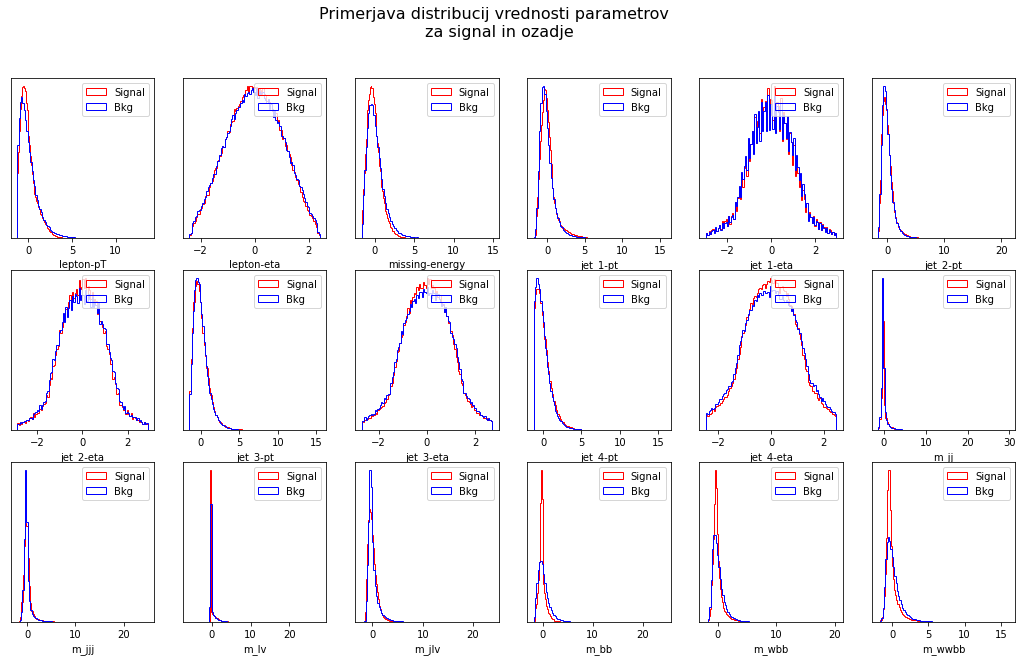

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7166171	best: 0.7166171 (0)	total: 55.7ms	remaining: 11.1s
1:	test: 0.7203550	best: 0.7203550 (1)	total: 104ms	remaining: 10.3s
2:	test: 0.7248776	best: 0.7248776 (2)	total: 148ms	remaining: 9.7s
3:	test: 0.7255667	best: 0.7255667 (3)	total: 206ms	remaining: 10.1s
4:	test: 0.7270083	best: 0.7270083 (4)	total: 254ms	remaining: 9.89s
5:	test: 0.7275366	best: 0.7275366 (5)	total: 309ms	remaining: 10s
6:	test: 0.7273960	best: 0.7275366 (5)	total: 359ms	remaining: 9.89s
7:	test: 0.7282509	best: 0.7282509 (7)	total: 405ms	remaining: 9.72s
8:	test: 0.7288777	best: 0.7288777 (8)	total: 446ms	remaining: 9.46s
9:	test: 0.7286613	best: 0.7288777 (8)	total: 485ms	remaining: 9.22s
10:	test: 0.7287392	best: 0.7288777 (8)	total: 528ms	remaining: 9.06s
11:	test: 0.7289843	best: 0.7289843 (11)	total: 567ms	remaining: 8.89s
12:	test: 0.7296505	best: 0.7296505 (12)	total: 614ms	remaining: 8.83s
13:	test: 0.7298283	best: 0.7298283 (13)	total: 658ms	remaining: 8.74s
14:	test: 0.7306365	best: 0.7

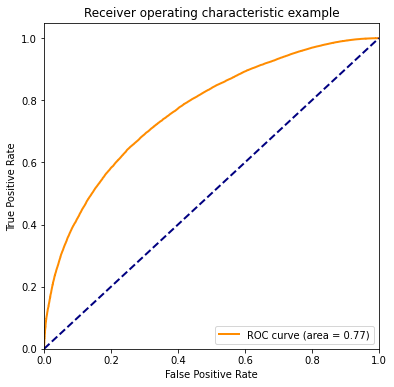

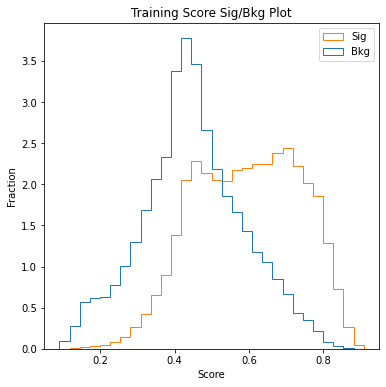

In [71]:
main(200)

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


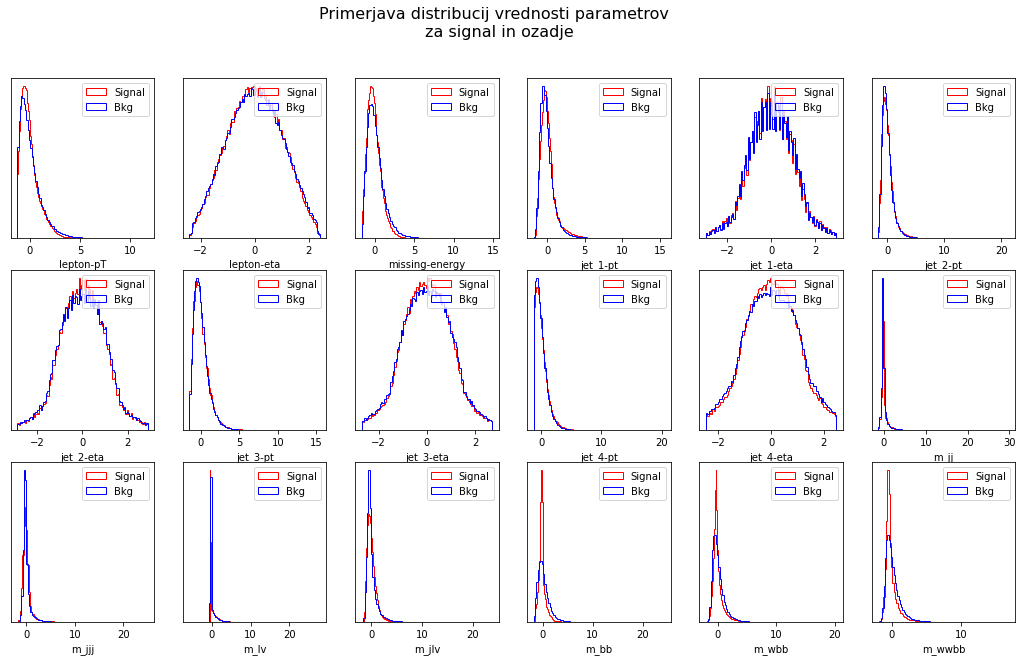

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7143010	best: 0.7143010 (0)	total: 45.8ms	remaining: 137ms
1:	test: 0.7302111	best: 0.7302111 (1)	total: 75.9ms	remaining: 75.9ms
2:	test: 0.7315868	best: 0.7315868 (2)	total: 107ms	remaining: 35.8ms
3:	test: 0.7327755	best: 0.7327755 (3)	total: 136ms	remaining: 0us

bestTest = 0.7327755443
bestIteration = 3

HERE0!
HERE!
HERE2!
score shape {} (100000,)
HERE3!
HERE4!
AUC score: 0.7304938555379377
logloss score: 0.6874587380788997
rmse score: 0.24715622067296852
rmse score: 0.24715622067296852


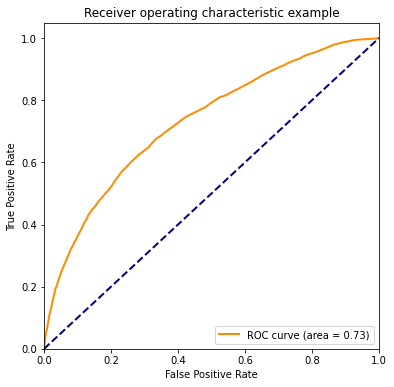

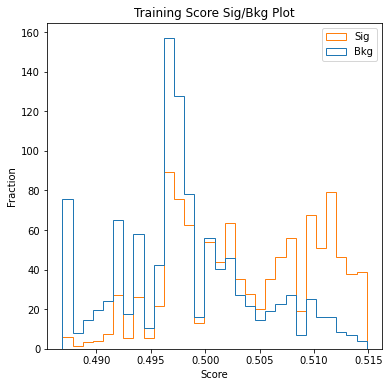

In [72]:

main(4)

In [84]:
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))


x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

#plot distributions
#plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)


# ready the data for Catboost
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())


ROC_data = []
AOC_data = []
time_data = []
loss_data = []
time_data = []
for i in range(0, 15):
    if i == 0:
        nepoch = 1
    else:
        nepoch = i*35
    print(nepoch)
    # CatBoost parameters
    eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
    task_type = 'CPU'  # if GPU else 'CPU'
    start = time.time()
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'

    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )


    #now train the model
    bdt.fit(
            pool_train,
            #early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=False # works when called through Ipython/jupyter
        )

    #plot & print results like ROC and score distribution etc...
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]

    print("score shape {}",y_score.shape)
    fake, true, _ = sklearn.metrics.roc_curve(y_val,y_score)
    #roc_auc = sklearn.metrics.auc(fake,true)
    ROC_data.append([fake, true])
    #loss_data.append[sklearn.metrics.log_loss(y_val,y_score)]
    
    end = time.time()
    time_data.append([nepoch, end - start])
    #plotting.plot_roc(y_val,y_score)

    #plotting.plot_score(y_val,y_score)
    
    auc=roc_auc_score(y_val,y_score)
    AOC_data.append(auc)
    print("AUC score: {}".format(auc))
    print("logloss score: {}".format(sklearn.metrics.log_loss(y_val,y_score)))
    print("rmse score: {}".format(sklearn.metrics.mean_squared_error(y_val,y_score)))
    print("rmse score: {}".format(sklearn.metrics.mean_squared_error(y_score, y_val)))
    #print("eval score: {}".format(bdt.evaluate(x_val,y_val)))
    #print("logloss score: {}".format(sklearn.metrics.accuracy_score(y_val,y_score)))

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
1
0:	test: 0.7162244	best: 0.7162244 (0)	total: 31.4ms	remaining: 0us

bestTest = 0.7162244362
bestIteration = 0

score shape {} (100000,)
AUC score: 0.7152377459303929
logloss score: 0.6916998193650613
rmse score: 0.2492763268582687
rmse score: 0.2492763268582687
35
0:	test: 0.7162244	best: 0.7162244 (0)	total: 31.9ms	remaining: 1.08s
1:	test: 0.7304262	best: 0.7304262 (1)	total: 62.7ms	remaining: 1.03s
2:	test: 0.7312836	best: 0.7312836 (2)	total: 92.9ms	remaining: 991ms
3:	test: 0.7322754	best: 0.7322754 (3)	total: 122ms	remaining: 948ms
4:	test: 0.7323985	best: 0.7323985

C:\Users\Ziga\AppData\Local\Temp\ipykernel_4184\4144508866.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=1, vmax=190)), ticks=np.linspace(1, 190, 10))


Text(0.5, 1.0, 'ROC za bdt')

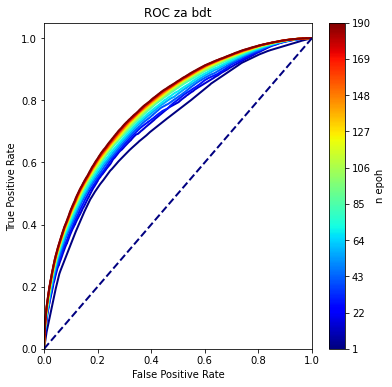

In [85]:
plt.figure(figsize=[6, 6])
num_curves = len(ROC_data)
colors = plt.cm.jet(np.linspace(0, 1, num_curves))
for i, data in enumerate(ROC_data):
    #plt.plot(i[0], i[1])
    fake, true = data
    roc_auc = sklearn.metrics.auc(fake,true)
    #roc_auc=1
    
    lw=2
    plt.plot(fake, true, color=colors[i] ,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=1, vmax=190)), ticks=np.linspace(1, 190, 10))
cbar.set_label('n epoh')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC za bdt')
#plt.savefig("ROCji.png")



#plt.legend(loc="lower right")


[  1.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190.]


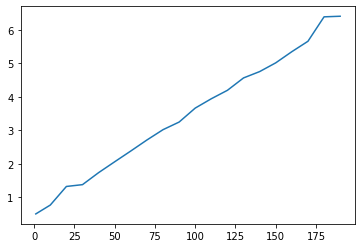

In [71]:
print(np.array(time_data)[:,0])
plt.plot(np.array(time_data)[:,0], np.array(time_data)[:,1])

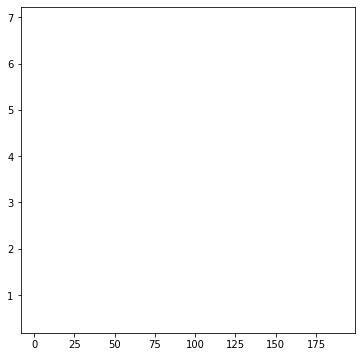

In [64]:
plt.figure(figsize=[6, 6])
num_curves = len(ROC_data)
colors = plt.cm.jet(np.linspace(0, 1, num_curves))
for i in range(len(time_data)):
    if i == 0:
        nepoch = 1
    else:
        nepoch = i*10
    plt.plot(nepoch, time_data[i], )

## Testni primeri

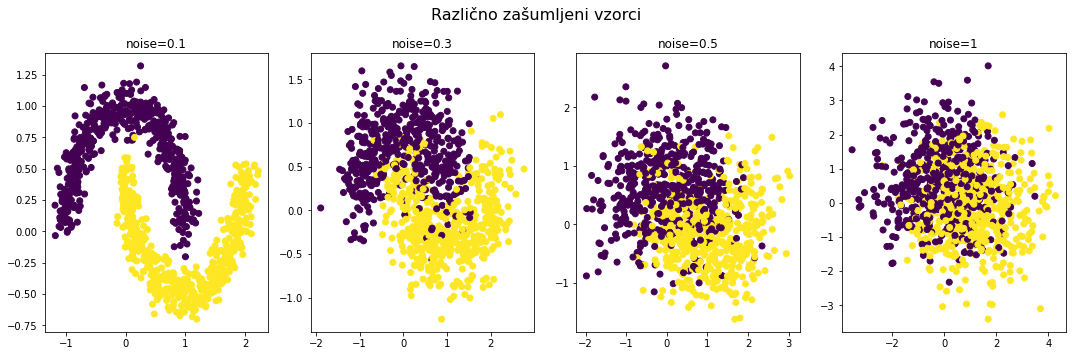

In [176]:
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=75, random_state=None)
#X, y = datasets.make_circles(n_samples=1000, noise=0.1)
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1) # 10% split
X_val, y_val = datasets.make_moons(n_samples=1000, shuffle=True, noise=.5, random_state=None)

#plt.scatter(X[:, 0], X[:, 1], c=y)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
axes[0].scatter(X[:, 0], X[:, 1], c=y)
axes[0].set_title('noise=0.1')
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.3, random_state=None)
axes[1].scatter(X[:, 0], X[:, 1], c=y)
axes[1].set_title('noise=0.3')
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.5, random_state=None)
axes[2].scatter(X[:, 0], X[:, 1], c=y)
axes[2].set_title('noise=0.5')
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=1, random_state=None)
axes[3].scatter(X[:, 0], X[:, 1], c=y)
axes[3].set_title('noise=1')
fig.suptitle("Različno zašumljeni vzorci", fontsize=16)
plt.tight_layout()
plt.savefig("primeri_sumov.png")

In [125]:
def main2(nepoch=100):
        # Training progress and eval results are shown as logging.INFO; so enables it.



    
    # ready the data for Catboost
    pool_train = Pool(data=X_train,label=y_train)
    pool_test = Pool(data=X_test,label=y_test)

    #NaKratko .... !
    
    # CatBoost parameters
    eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
    task_type = 'CPU'  # if GPU else 'CPU'
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'
    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )

    
    #now train the model
    bdt.fit(
            pool_train,
            #early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=True # works when called through Ipython/jupyter
        )
    print("HERE0!")

    #print()
    print("HERE!")
    #plot & print results like ROC and score distribution etc...
    y_score=bdt.predict_proba(X_val)[:,1]
    print("HERE2!")
    print("score shape {}",y_score.shape)
    print("HERE3!")
    plotting.plot_roc(y_val,y_score)
    print("HERE4!")
    plotting.plot_score(y_val,y_score)
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))
    print("logloss score: {}".format(sklearn.metrics.log_loss(y_val,y_score)))
    #print("logloss score: {}".format(sklearn.metrics.accuracy_score(y_val,y_score)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6642512	best: 0.6642512 (0)	total: 3.25ms	remaining: 32.5s
1:	test: 0.6793478	best: 0.6793478 (1)	total: 5.92ms	remaining: 29.6s
2:	test: 0.6952496	best: 0.6952496 (2)	total: 8.73ms	remaining: 29.1s
3:	test: 0.6807568	best: 0.6952496 (2)	total: 11.7ms	remaining: 29.2s
4:	test: 0.6763285	best: 0.6952496 (2)	total: 14.5ms	remaining: 29s
5:	test: 0.6704911	best: 0.6952496 (2)	total: 17.5ms	remaining: 29.2s
6:	test: 0.6767311	best: 0.6952496 (2)	total: 20.5ms	remaining: 29.2s
7:	test: 0.6789452	best: 0.6952496 (2)	total: 23.2ms	remaining: 29s
8:	test: 0.6827697	best: 0.6952496 (2)	total: 26.1ms	remaining: 28.9s
9:	test: 0.6831723	best: 0.6952496 (2)	total: 28.9ms	remaining: 28.9s
10:	test: 0.6799517	best: 0.6952496 (2)	total: 31.9ms	remaining: 28.9s
11:	test: 0.6809581	best: 0.6952496 (2)	total: 34.6ms	remaining: 28.8s
12:	test: 0.6757246	best: 0.6952496 (2)	total: 37.5ms	remaining: 28.8s
13:	test: 0.6729066	best: 0.6952496 (2)	total: 40.3ms	remaining: 28.8s
14:	test: 0.6741143	

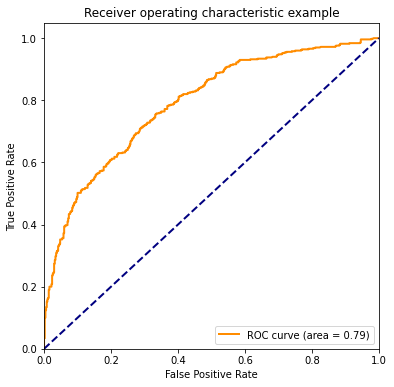

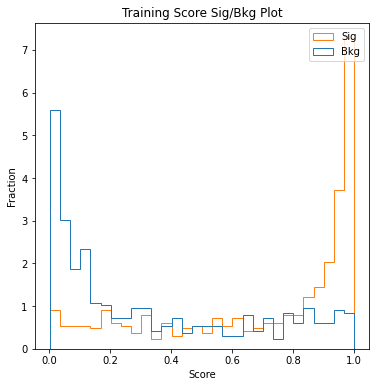

In [134]:
#main2(10000)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf
print("TensorFlow version ",tf.__version__)
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn import datasets

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4930 - loss: 3.6932   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4828 - loss: 0.9122 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5362 - loss: 0.7518 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5335 - loss: 0.7416 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5205 - loss: 0.7394 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5216 - loss: 0.7384 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5070 - loss: 0.7374 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5144 - loss: 0.7359 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5108 - loss: 0.7333 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5059 - loss: 0.7323 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5056 - loss: 0.7331 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

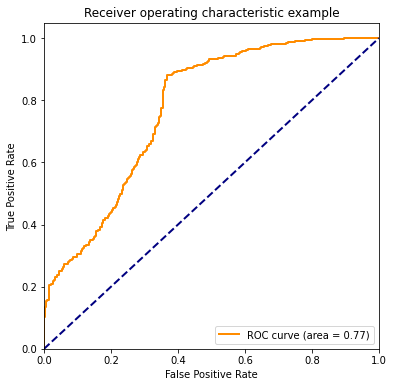

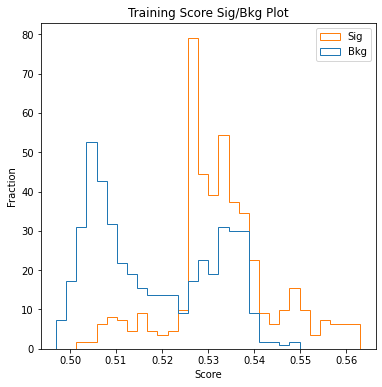

In [148]:
nepoch=50

dnn = Sequential()
dnn.add(Dense(50, input_dim=2, activation='relu'))
dnn.add(Dense(50, input_dim=2, activation='relu'))
dnn.add(Dense(1, activation='sigmoid')) # output layer/value
#plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])

dnn.summary()

#optional early stopping
eval_metric = 'AUC'


#run the training
dnn_model_history = dnn.fit(X, y, epochs=nepoch)

#plot training history
print("history values",dnn_model_history.history.keys())
# plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
# plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
# plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
#plotting.plot_history([('DNN model', dnn_model_history),])

#plot & print results like ROC and score distribution etc...
y_score=dnn.predict(X_val)[:,0]
plotting.plot_roc(y_val,y_score)
plotting.plot_score(y_val,y_score)
print("loss:", dnn.evaluate(X_val, y_val))
auc=roc_auc_score(y_val,y_score)
print("AUC score: {}".format(auc))

In [149]:
sum = []
for i in range(1, 21):
    no = 1/20*i
    X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=no, random_state=None)
    #X, y = datasets.make_circles(n_samples=1000, noise=0.1)
    X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1) # 10% split
    X_val, y_val = datasets.make_moons(n_samples=1000, shuffle=True, noise=.3, random_state=None)

    nepoch=50

    dnn = Sequential()
    dnn.add(Dense(50, input_dim=2, activation='relu'))
    dnn.add(Dense(50, input_dim=2, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    #plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'


    #run the training
    dnn_model_history = dnn.fit(X, y, epochs=nepoch)

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(X_val)[:,0]
    #plotting.plot_roc(y_val,y_score)
    #plotting.plot_score(y_val,y_score)
    print("loss:", dnn.evaluate(X_val, y_val))
    auc=roc_auc_score(y_val,y_score)
    sum.append([no, auc])
    print("AUC score: {}".format(auc))

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_213 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6120 - loss: 0.6401   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8046 - loss: 0.4822 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8457 - loss: 0.3593 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8654 - loss: 0.2922 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8766 - loss: 0.2604 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8887 - loss: 0.2391 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8986 - loss: 0.2196 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9097 - loss: 0.1983 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9212 - loss: 0.1779 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9298 - loss: 0.1589 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9348 - loss: 0.1410 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7570 - loss: 0.6028
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.4047
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8734 - loss: 0.2998 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8844 - loss: 0.2582 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8941 - loss: 0.2393 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8942 - loss: 0.2267 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.2157 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8998 - loss: 0.2045 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9046 - loss: 0.1913 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9128 - loss: 0.1756 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9319 - loss: 0.1584 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_219 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6990 - loss: 0.6445
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8555 - loss: 0.4490 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8655 - loss: 0.3180 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8803 - loss: 0.2674 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8877 - loss: 0.2470 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.2343 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9005 - loss: 0.2240 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9035 - loss: 0.2133 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9088 - loss: 0.2029 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9177 - loss: 0.1914 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.1781 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7445 - loss: 0.6265
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8429 - loss: 0.4419 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8441 - loss: 0.3597 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8475 - loss: 0.3329 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8539 - loss: 0.3175 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 0.3075 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8619 - loss: 0.2997 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8668 - loss: 0.2931 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8730 - loss: 0.2867 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8828 - loss: 0.2797 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8904 - loss: 0.2707 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7058 - loss: 0.6286   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7940 - loss: 0.4699 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8569 - loss: 0.3554 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.3154 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8673 - loss: 0.3030
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8675 - loss: 0.2935 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8787 - loss: 0.2833 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8795 - loss: 0.2730 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8854 - loss: 0.2622 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8952 - loss: 0.2509 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9051 - loss: 0.2394 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6288 - loss: 0.6632   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8466 - loss: 0.4882 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8554 - loss: 0.3716 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8555 - loss: 0.3420 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.3356 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8629 - loss: 0.3309 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8641 - loss: 0.3269 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8618 - loss: 0.3231 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8618 - loss: 0.3196 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8627 - loss: 0.3159 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8633 - loss: 0.3122 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5402 - loss: 0.6839   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8462 - loss: 0.4978 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8501 - loss: 0.3794 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.3407 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8524 - loss: 0.3313 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8606 - loss: 0.3268 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8657 - loss: 0.3234 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.3205
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8601 - loss: 0.3177 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.3149 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8632 - loss: 0.3122 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_234 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6717 - loss: 0.6661   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8235 - loss: 0.5128 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8273 - loss: 0.4019 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8304 - loss: 0.3744 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8401 - loss: 0.3708 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8406 - loss: 0.3679 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8432 - loss: 0.3656 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8432 - loss: 0.3637 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8431 - loss: 0.3622 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8436 - loss: 0.3608 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8451 - loss: 0.3595 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_237 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6065 - loss: 0.6617   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7807 - loss: 0.4984 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8036 - loss: 0.4390 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8136 - loss: 0.4311 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8130 - loss: 0.4293 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8158 - loss: 0.4281 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8147 - loss: 0.4273 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8150 - loss: 0.4264 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8155 - loss: 0.4254 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8155 - loss: 0.4248 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8162 - loss: 0.4240 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6046 - loss: 0.6655   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 0.4935 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8109 - loss: 0.4242 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.4151 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8170 - loss: 0.4134 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8185 - loss: 0.4121 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8187 - loss: 0.4108 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8204 - loss: 0.4097
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8197 - loss: 0.4086 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.8197 - loss: 0.4076
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8197 - loss: 0.4065 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_243 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7466 - loss: 0.6211   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7790 - loss: 0.5013 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.4634 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4599 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.4598 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7829 - loss: 0.4596 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7847 - loss: 0.4593 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.4591  
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.4589 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.4587 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 0.4586 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6776 - loss: 0.6395   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7577 - loss: 0.5351 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7705 - loss: 0.4992 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7779 - loss: 0.4973 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7699 - loss: 0.4960 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7711 - loss: 0.4943 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7738 - loss: 0.4929 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7729 - loss: 0.4918 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7729 - loss: 0.4907 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7760 - loss: 0.4898 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7760 - loss: 0.4890 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_249 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6563 - loss: 0.6326   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7785 - loss: 0.5106 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7763 - loss: 0.4780 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.4726 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.4708 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7753 - loss: 0.4697 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.4688 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7783 - loss: 0.4680 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7781 - loss: 0.4673 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7814 - loss: 0.4668 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7815 - loss: 0.4663 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.6740
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7622 - loss: 0.5272 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7609 - loss: 0.4939 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7631 - loss: 0.4911 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7667 - loss: 0.4902 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7675 - loss: 0.4891 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7683 - loss: 0.4883  
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7660 - loss: 0.4876
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7653 - loss: 0.4870 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7653 - loss: 0.4864 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7680 - loss: 0.4859 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6897 - loss: 0.6172
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7777 - loss: 0.5185 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7732 - loss: 0.4878 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7735 - loss: 0.4840 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.4828 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 0.4819 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7784 - loss: 0.4810 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7773 - loss: 0.4803 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7771 - loss: 0.4797 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7778 - loss: 0.4791 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7780 - loss: 0.4786 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6481 - loss: 0.6537   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7183 - loss: 0.5641 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7169 - loss: 0.5577 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7166 - loss: 0.5577 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7166 - loss: 0.5566 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7165 - loss: 0.5558 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7187 - loss: 0.5550 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7233 - loss: 0.5545 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7208 - loss: 0.5539 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7208 - loss: 0.5533 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7200 - loss: 0.5529 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_261 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5653 - loss: 0.6695   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7419 - loss: 0.5590 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7392 - loss: 0.5351 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7406 - loss: 0.5333 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7338 - loss: 0.5326 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7338 - loss: 0.5322 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7342 - loss: 0.5319 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7342 - loss: 0.5317 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7331 - loss: 0.5315 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7335 - loss: 0.5312 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7338 - loss: 0.5310 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_264 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5867 - loss: 0.6456   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7158 - loss: 0.5845 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7145 - loss: 0.5672 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7171 - loss: 0.5665 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7165 - loss: 0.5663 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7176 - loss: 0.5658 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5655 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7196 - loss: 0.5653 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7196 - loss: 0.5650 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7180 - loss: 0.5648 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7180 - loss: 0.5646 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_267 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6361 - loss: 0.6497
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7133 - loss: 0.5678
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7200 - loss: 0.5502 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5484 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5480 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7217 - loss: 0.5477 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7217 - loss: 0.5474 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7219 - loss: 0.5471 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7218 - loss: 0.5468 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7218 - loss: 0.5466 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7216 - loss: 0.5463 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_270 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6806 - loss: 0.6467   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7178 - loss: 0.5863 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7103 - loss: 0.5785 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7136 - loss: 0.5794 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7102 - loss: 0.5794 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7103 - loss: 0.5792 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7110 - loss: 0.5791 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7088 - loss: 0.5789 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7078 - loss: 0.5788 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7078 - loss: 0.5787 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7078 - loss: 0.5786 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [158]:
sum2 = []
for i in range(1, 41):
    print("i: ", i)
    no = 1 + 5/40*i
    X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=no, random_state=None)
    #X, y = datasets.make_circles(n_samples=1000, noise=0.1)
    X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1) # 10% split
    X_val, y_val = datasets.make_moons(n_samples=1000, shuffle=True, noise=.3, random_state=None)

    nepoch=50

    dnn = Sequential()
    dnn.add(Dense(50, input_dim=2, activation='relu'))
    dnn.add(Dense(50, input_dim=2, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    #plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'


    #run the training
    dnn_model_history = dnn.fit(X, y, epochs=nepoch)

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(X_val)[:,0]
    #plotting.plot_roc(y_val,y_score)
    #plotting.plot_score(y_val,y_score)
    print("loss:", dnn.evaluate(X_val, y_val))
    auc=roc_auc_score(y_val,y_score)
    sum2.append([no, auc])
    print("AUC score: {}".format(auc))

i:  1


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_393 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5555 - loss: 0.6799
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 0.6255 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 0.6208 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6551 - loss: 0.6183 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6551 - loss: 0.6166 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.6156 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6556 - loss: 0.6150 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 0.6145 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6498 - loss: 0.6142 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6498 - loss: 0.6139 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 0.6137 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_396 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4834 - loss: 0.6927
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6921 - loss: 0.5842  
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6993 - loss: 0.5757 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7035 - loss: 0.5755 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6926 - loss: 0.5749 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.6970 - loss: 0.5746
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7017 - loss: 0.5743 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7047 - loss: 0.5739 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7062 - loss: 0.5737 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7062 - loss: 0.5734 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7062 - loss: 0.5733 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_399 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5714 - loss: 0.6783   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6940 - loss: 0.5931 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6922 - loss: 0.5845 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6896 - loss: 0.5828 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6932 - loss: 0.5818 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6869 - loss: 0.5810 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6866 - loss: 0.5804 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6916 - loss: 0.5799 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6928 - loss: 0.5794 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6914 - loss: 0.5789
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6920 - loss: 0.5786 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_402 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6307 - loss: 0.6625   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6565 - loss: 0.6312 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6596 - loss: 0.6284 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6571 - loss: 0.6270 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.6261 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6603 - loss: 0.6255 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6591 - loss: 0.6251 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6630 - loss: 0.6247 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.6243 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6677 - loss: 0.6239 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6677 - loss: 0.6237 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_405 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5476 - loss: 0.6927   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 0.6336 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6441 - loss: 0.6345 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 0.6342 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.6338 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6464 - loss: 0.6334 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 0.6331 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6487 - loss: 0.6329 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 0.6327 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6471 - loss: 0.6324 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6466 - loss: 0.6320 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_408 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6170 - loss: 0.6583
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6224 - loss: 0.6424
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - loss: 0.6397 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6168 - loss: 0.6388 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6176 - loss: 0.6381 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6207 - loss: 0.6375 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6202 - loss: 0.6371 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6183 - loss: 0.6366 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.6199 - loss: 0.6361
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6179 - loss: 0.6358 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6193 - loss: 0.6354 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_411 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5691 - loss: 0.6829   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 0.6594 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.6603 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.6594 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 0.6597 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 0.6593 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6266 - loss: 0.6592 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 0.6589 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 0.6588 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6252 - loss: 0.6589 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.6587 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_414 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6448 - loss: 0.6614   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6556 - loss: 0.6330 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 0.6309 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6589 - loss: 0.6303 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6295 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6289 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6285 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6281 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6278 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6275 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 0.6273 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_417 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5831 - loss: 0.6713   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 0.6579 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.6561 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6042 - loss: 0.6560 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 0.6558 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6088 - loss: 0.6556 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 0.6554 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6122 - loss: 0.6553 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6129 - loss: 0.6552 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6141 - loss: 0.6550 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6132 - loss: 0.6550 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5973 - loss: 0.6616   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6533 - loss: 0.6222 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6529 - loss: 0.6205 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6527 - loss: 0.6203 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6646 - loss: 0.6201 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6643 - loss: 0.6200 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.6198 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 0.6197 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6632 - loss: 0.6195 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 0.6193 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6606 - loss: 0.6192 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_423 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5105 - loss: 0.7154   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6137 - loss: 0.6621 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6118 - loss: 0.6604 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 0.6600 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5988 - loss: 0.6591 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5969 - loss: 0.6586 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5987 - loss: 0.6580 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6010 - loss: 0.6575 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6039 - loss: 0.6571 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6022 - loss: 0.6568 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6017 - loss: 0.6565 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_426 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5255 - loss: 0.6933   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5832 - loss: 0.6667 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5802 - loss: 0.6660 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5845 - loss: 0.6655 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5858 - loss: 0.6650 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5937 - loss: 0.6647 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6040 - loss: 0.6644 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6011 - loss: 0.6642 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6018 - loss: 0.6640 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5923 - loss: 0.6638 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5955 - loss: 0.6635 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_429 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5759 - loss: 0.6715   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 0.6518 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6336 - loss: 0.6495 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 0.6488 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 0.6480 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6408 - loss: 0.6473 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 0.6468 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6434 - loss: 0.6463 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6438 - loss: 0.6458 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 0.6454 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6418 - loss: 0.6450 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_432 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_434 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5694 - loss: 0.6833   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5889 - loss: 0.6642 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5881 - loss: 0.6625 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5907 - loss: 0.6616 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5920 - loss: 0.6612 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5927 - loss: 0.6608 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5946 - loss: 0.6605 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 0.6602 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5983 - loss: 0.6601 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5961 - loss: 0.6599 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5971 - loss: 0.6597 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_435 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_436 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4958 - loss: 0.7478   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6063 - loss: 0.6590 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.6586 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6030 - loss: 0.6580 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.6577 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 0.6573 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6100 - loss: 0.6571 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6094 - loss: 0.6568 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6122 - loss: 0.6568 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.6563 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6177 - loss: 0.6561 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_438 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_440 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5326 - loss: 0.7195
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 0.6764
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5782 - loss: 0.6765 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 0.6760 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5826 - loss: 0.6759 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5803 - loss: 0.6756 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5817 - loss: 0.6754 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5816 - loss: 0.6752 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.6750 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5836 - loss: 0.6750 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5818 - loss: 0.6748 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_441 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5572 - loss: 0.6858   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5784 - loss: 0.6729 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5852 - loss: 0.6696 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5809 - loss: 0.6682 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5730 - loss: 0.6677 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.6671 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5858 - loss: 0.6667 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5855 - loss: 0.6662 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5851 - loss: 0.6658 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6655 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5750 - loss: 0.6652
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_444 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4432 - loss: 0.7297   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 0.6724 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5960 - loss: 0.6691 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 0.6674 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5965 - loss: 0.6665 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.6659 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5975 - loss: 0.6655 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5987 - loss: 0.6650 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6000 - loss: 0.6646 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5990 - loss: 0.6642 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6002 - loss: 0.6638 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_447 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_448 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5351 - loss: 0.7029   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6074 - loss: 0.6751 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6037 - loss: 0.6735 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6032 - loss: 0.6727 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 0.6725 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 0.6721 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6093 - loss: 0.6720 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6081 - loss: 0.6716 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6076 - loss: 0.6714 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 0.6713 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6069 - loss: 0.6711 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_450 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5165 - loss: 0.7085   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6023 - loss: 0.6757 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5658 - loss: 0.6777 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5651 - loss: 0.6773 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5724 - loss: 0.6769 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 0.6769 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 0.6767 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5766 - loss: 0.6765 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5778 - loss: 0.6763 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5792 - loss: 0.6763 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5765 - loss: 0.6763 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_453 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_455 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5347 - loss: 0.6923    
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5848 - loss: 0.6868 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5798 - loss: 0.6845 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5799 - loss: 0.6838 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5811 - loss: 0.6832 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5771 - loss: 0.6830 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5766 - loss: 0.6826 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5763 - loss: 0.6822 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5767 - loss: 0.6821 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5746 - loss: 0.6818 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5751 - loss: 0.6817 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_456 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5067 - loss: 0.7106 
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5420 - loss: 0.6836 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6820 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5496 - loss: 0.6810
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 0.6802 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5549 - loss: 0.6796 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6793 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5564 - loss: 0.6789 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5546 - loss: 0.6785 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5503 - loss: 0.6783 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 0.6780 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_459 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5174 - loss: 0.7010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5276 - loss: 0.6944
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5587 - loss: 0.6910 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 0.6883 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5460 - loss: 0.6881 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5449 - loss: 0.6875 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.6869 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5528 - loss: 0.6868 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5466 - loss: 0.6867 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5503 - loss: 0.6861 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5548 - loss: 0.6858 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_462 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5289 - loss: 0.7121   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5582 - loss: 0.6955 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5682 - loss: 0.6913 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5749 - loss: 0.6893 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5739 - loss: 0.6886
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5643 - loss: 0.6883 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5657 - loss: 0.6881 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.6875 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5673 - loss: 0.6877
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5672 - loss: 0.6872 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5668 - loss: 0.6873 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_465 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5289 - loss: 0.7129   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5699 - loss: 0.6851 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5742 - loss: 0.6815 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5836 - loss: 0.6804 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5764 - loss: 0.6796 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5781 - loss: 0.6791 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.6787 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5753 - loss: 0.6783 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5767 - loss: 0.6779 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.6776 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5871 - loss: 0.6772 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_468 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5634 - loss: 0.6958   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5649 - loss: 0.6840 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5633 - loss: 0.6823 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5702 - loss: 0.6816 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6811 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 0.6806 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5774 - loss: 0.6802 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 0.6799 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5730 - loss: 0.6796 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5721 - loss: 0.6793 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6791 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_471 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_472 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5239 - loss: 0.7060   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5543 - loss: 0.6962 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 0.6868 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5452 - loss: 0.6878 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5446 - loss: 0.6873 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5381 - loss: 0.6872 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5324 - loss: 0.6870 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5476 - loss: 0.6872 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5321 - loss: 0.6876 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 0.6871 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5480 - loss: 0.6869 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_474 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_476 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5586 - loss: 0.7018   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5760 - loss: 0.6832 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5649 - loss: 0.6804 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5575 - loss: 0.6791 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5647 - loss: 0.6790 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5608 - loss: 0.6785 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5795 - loss: 0.6778
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5790 - loss: 0.6775 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5762 - loss: 0.6772 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5831 - loss: 0.6769 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5806 - loss: 0.6767 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_477 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5306 - loss: 0.7183   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 0.6892 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5686 - loss: 0.6880 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.6862 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5757 - loss: 0.6854 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5752 - loss: 0.6846 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5790 - loss: 0.6842 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5764 - loss: 0.6841 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5753 - loss: 0.6839 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5747 - loss: 0.6836 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5746 - loss: 0.6834 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_480 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5639 - loss: 0.7046   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5515 - loss: 0.6909 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5534 - loss: 0.6903 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 0.6885 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5491 - loss: 0.6878 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5485 - loss: 0.6873 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5513 - loss: 0.6869 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5523 - loss: 0.6865 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5522 - loss: 0.6863 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5553 - loss: 0.6860 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5559 - loss: 0.6859 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_483 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5315 - loss: 0.8214   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5606 - loss: 0.7001 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5607 - loss: 0.6852 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5674 - loss: 0.6854 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5743 - loss: 0.6848 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5729 - loss: 0.6838 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5697 - loss: 0.6830 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5726 - loss: 0.6826 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5700 - loss: 0.6820 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5704 - loss: 0.6822 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5639 - loss: 0.6815 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_486 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5126 - loss: 0.7168   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 0.6950 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 0.6930
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5650 - loss: 0.6920 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5654 - loss: 0.6914 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5707 - loss: 0.6908 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.6906 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5658 - loss: 0.6901 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5629 - loss: 0.6897 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5607 - loss: 0.6896 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5594 - loss: 0.6893 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_489 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_490 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5405 - loss: 0.7858   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5261 - loss: 0.6912 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5493 - loss: 0.6847 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5334 - loss: 0.6824 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5345 - loss: 0.6818 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5366 - loss: 0.6812 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5560 - loss: 0.6809 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5458 - loss: 0.6805 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5449 - loss: 0.6798 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5380 - loss: 0.6796 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5458 - loss: 0.6792 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_492 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4783 - loss: 0.7733 
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5058 - loss: 0.6930 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5449 - loss: 0.6871 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5596 - loss: 0.6867 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5576 - loss: 0.6864 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6859 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5579 - loss: 0.6855 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5525 - loss: 0.6851 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5520 - loss: 0.6849 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5509 - loss: 0.6848 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5423 - loss: 0.6847 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_495 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_496 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5277 - loss: 0.6992   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5054 - loss: 0.7069 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5084 - loss: 0.7077 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5167 - loss: 0.7034 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5102 - loss: 0.7014
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.7004 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5221 - loss: 0.6991 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5182 - loss: 0.6992 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5142 - loss: 0.6981 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5181 - loss: 0.6976 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 0.6976
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_498 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4848 - loss: 0.7525   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5307 - loss: 0.6900 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 0.6904 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5653 - loss: 0.6874 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5528 - loss: 0.6874 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5519 - loss: 0.6869 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5516 - loss: 0.6864 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5540 - loss: 0.6861 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6857 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5569 - loss: 0.6854 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5527 - loss: 0.6852 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_501 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5386 - loss: 0.7234   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5374 - loss: 0.6911 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5522 - loss: 0.6860 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5546 - loss: 0.6854 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5462 - loss: 0.6849 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5517 - loss: 0.6846 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5631 - loss: 0.6839 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5586 - loss: 0.6836 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5683 - loss: 0.6832 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5653 - loss: 0.6830 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5633 - loss: 0.6829 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4809 - loss: 0.7810   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5696 - loss: 0.6878 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5649 - loss: 0.6855 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5854 - loss: 0.6840 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5820 - loss: 0.6829 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5783 - loss: 0.6816 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5757 - loss: 0.6811 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5733 - loss: 0.6807 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5702 - loss: 0.6805 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 0.6799 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5676 - loss: 0.6798 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_507 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5534 - loss: 0.7083   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5181 - loss: 0.6978 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5276 - loss: 0.6893 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5302 - loss: 0.6887
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5303 - loss: 0.6877 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5471 - loss: 0.6868 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.6859 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5463 - loss: 0.6854 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5454 - loss: 0.6846 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5445 - loss: 0.6842 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5428 - loss: 0.6838 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_510 (Dense)               │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751 (10.75 KB)

 Trainable params: 2,751 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5345 - loss: 0.7478   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.6989 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5578 - loss: 0.6962 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5524 - loss: 0.6938 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5532 - loss: 0.6925 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5502 - loss: 0.6919 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5442 - loss: 0.6915 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5416 - loss: 0.6906 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.6903 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.6900 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5402 - loss: 0.6897 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

[6.      0.71753]


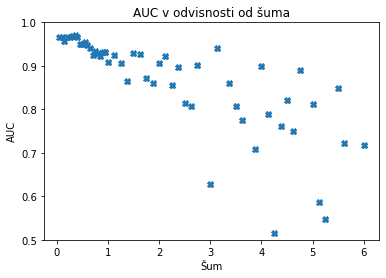

<Figure size 432x288 with 0 Axes>

In [167]:
sum3 = np.concatenate((sum, sum2), axis=0)
print(sum3[-1,:])
plt.plot(sum3[:,0], sum3[:,1], linestyle="None", marker="X")
plt.ylim([0.5, 1])
plt.xlabel('Šum')
plt.ylabel('AUC')
plt.title('AUC v odvisnosti od šuma')
#plt.savefig("zasumljeno.png")
plt.show()
plt.clf()


#plt.plot(sum3[:21,0], sum3[:21,1], linestyle="None", marker="X")
#plt.ylim([0.5, 1])

## Nevronske

In [17]:
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

#print(x_trn.shape)
#print(np.delete(x_trn, 6, axis=1).shape)

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#some plotting routines
import plotting

# data processing
import data_higgs as dh

#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

TensorFlow version  2.16.1


In [19]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [20]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data
    #prepare the data => normalizations !

    # split
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only

    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [52]:
def main(nepoch=10):
      # Training progress and eval results are shown as logging.INFO; so enables it.

    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    #plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))

    # build a model - a DNN in TF 2.0
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
            mode='max',
            monitor='val_' + eval_metric,
            patience=5,
            min_delta=0.00001,
            verbose=1
        )

    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    print("loss:", dnn.evaluate(x_val.to_numpy(), y_val.to_numpy()))
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
Steps train:3600 and test:400
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6030 - loss: 0.6556 - val_accuracy: 0.6586 - val_loss: 0.6170
Epoch 2/3
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6577 - loss: 0.6156 - val_accuracy: 0.6801 - val_loss: 0.5961
Epoch 3/3
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6768 - loss: 0.5964 - val_accuracy: 0.6930 - val_loss: 0.5826
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 963us/step - accuracy: 0.6736 - loss: 0.6047
loss: [0.6060585975646973, 0.6723700165748596]
AUC score: 0.7382264385786499


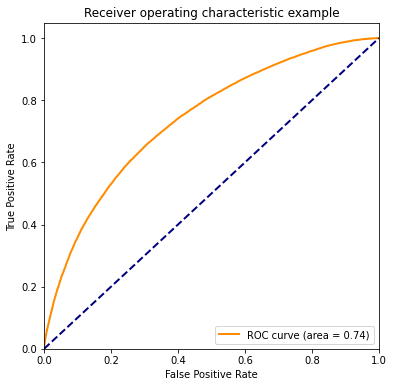

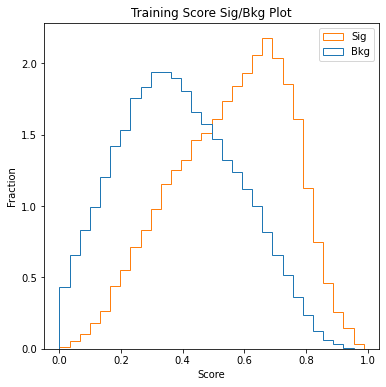

In [51]:
main(3)

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
Steps train:3600 and test:400
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6010 - loss: 0.6562 - val_accuracy: 0.6560 - val_loss: 0.6158
Epoch 2/2
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6589 - loss: 0.6138 - val_accuracy: 0.6776 - val_loss: 0.5920
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 885us/step - accuracy: 0.6653 - loss: 0.6072
loss: [0.607250988483429, 0.6649500131607056]
AUC score: 0.7296554997957113


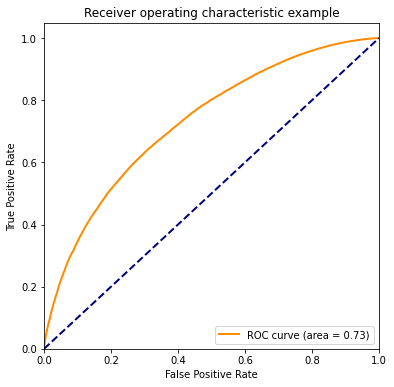

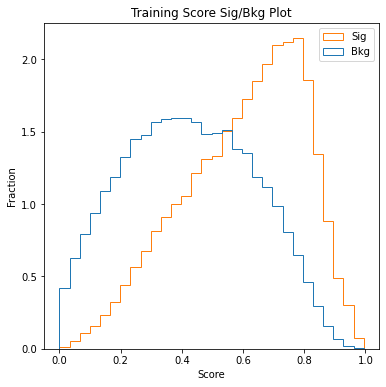

In [45]:
main(2)

In [91]:
nepoch = 3
    # Training progress and eval results are shown as logging.INFO; so enables it.

#needs to be done once if the h5 files need to be recreated...
#dh.download_and_make_data()

hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))


zmanjsano_data = []
for i in range(18):
    print("stolpec:", i)
    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_trn_new = pd.DataFrame(np.delete(x_trn, i, axis=1))
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_train_new = pd.DataFrame(np.delete(x_train, i, axis=1))
    x_test_new = pd.DataFrame(np.delete(x_test, i, axis=1))
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
    x_val_new = pd.DataFrame(np.delete(x_val, i, axis=1))

    #print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    #plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train_new.to_numpy(),y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test_new.to_numpy(),y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train_new.shape[0]/BATCH_SIZE)
    test_steps=int(x_test_new.shape[0]/BATCH_SIZE)
    #print("Steps train:{} and test:{}".format(train_steps,test_steps))

    # build a model - a DNN in TF 2.0
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims-1, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims-1, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    # earlystop_callback = EarlyStopping(
    #         mode='max',
    #         monitor='val_' + eval_metric,
    #         patience=5,
    #         min_delta=0.00001,
    #         verbose=1
    #     )

    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val_new.to_numpy())[:,0]
    #plotting.plot_roc(y_val,y_score)
    #plotting.plot_score(y_val,y_score)
    print()
    auc=roc_auc_score(y_val,y_score)
    loss = dnn.evaluate(x_val_new.to_numpy(), y_val.to_numpy())
    zmanjsano_data.append([i, auc, loss[-1]])
    print("AUC score: {}".format(auc))


Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
stolpec: 0
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6129 - loss: 0.6497 - val_accuracy: 0.6800 - val_loss: 0.5968
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6876 - loss: 0.5901 - val_accuracy: 0.6999 - val_loss: 0.5743
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7017 - loss: 0.5700 - val_accuracy: 0.7064 - val_loss: 0.5646
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step - accuracy: 0.7080 - loss: 0.5609
AUC score: 0.7809086654775292
stolpec: 1
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6205 - loss: 0.6453 - val_accuracy: 0.6900 - val_loss: 0.5901
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6996 - loss: 0.5779 - val_accuracy: 0.7044 - val_loss: 0.5701
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7112 - loss: 0.5612 - val_accuracy: 0.7097 - val_loss: 0.5609
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 866us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step - accuracy: 0.7156 - loss: 0.5538
AUC score: 0.7875773525648593
stolpec: 2
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6098 - loss: 0.6492 - val_accuracy: 0.6868 - val_loss: 0.5905
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6937 - loss: 0.5831 - val_accuracy: 0.7023 - val_loss: 0.5701
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7055 - loss: 0.5664 - val_accuracy: 0.7088 - val_loss: 0.5617
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 823us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.7110 - loss: 0.5592
AUC score: 0.7834405672019924
stolpec: 3
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6096 - loss: 0.6521 - val_accuracy: 0.6792 - val_loss: 0.6013
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6856 - loss: 0.5922 - val_accuracy: 0.7017 - val_loss: 0.5744
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7016 - loss: 0.5701 - val_accuracy: 0.7110 - val_loss: 0.5623
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - accuracy: 0.7069 - loss: 0.5638
AUC score: 0.778839040418713
stolpec: 4
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6211 - loss: 0.6429 - val_accuracy: 0.6949 - val_loss: 0.5853
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6974 - loss: 0.5794 - val_accuracy: 0.7089 - val_loss: 0.5635
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7103 - loss: 0.5606 - val_accuracy: 0.7158 - val_loss: 0.5533
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 836us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 881us/step - accuracy: 0.7159 - loss: 0.5532
AUC score: 0.788530532408412
stolpec: 5
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6152 - loss: 0.6439 - val_accuracy: 0.6931 - val_loss: 0.5866
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6955 - loss: 0.5803 - val_accuracy: 0.7087 - val_loss: 0.5647
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7088 - loss: 0.5626 - val_accuracy: 0.7143 - val_loss: 0.5553
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 867us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 889us/step - accuracy: 0.7145 - loss: 0.5550
AUC score: 0.7869682278450238
stolpec: 6
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6178 - loss: 0.6446 - val_accuracy: 0.6883 - val_loss: 0.5898
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6957 - loss: 0.5812 - val_accuracy: 0.7045 - val_loss: 0.5676
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7083 - loss: 0.5626 - val_accuracy: 0.7115 - val_loss: 0.5569
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 772us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - accuracy: 0.7124 - loss: 0.5551
AUC score: 0.787153929849465
stolpec: 7
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6152 - loss: 0.6494 - val_accuracy: 0.6912 - val_loss: 0.5890
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6973 - loss: 0.5800 - val_accuracy: 0.7120 - val_loss: 0.5632
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7105 - loss: 0.5600 - val_accuracy: 0.7172 - val_loss: 0.5526
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.7152 - loss: 0.5535
AUC score: 0.7887595780173532
stolpec: 8
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6267 - loss: 0.6410 - val_accuracy: 0.6863 - val_loss: 0.5892
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6985 - loss: 0.5786 - val_accuracy: 0.7041 - val_loss: 0.5688
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7110 - loss: 0.5601 - val_accuracy: 0.7131 - val_loss: 0.5565
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 835us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 876us/step - accuracy: 0.7154 - loss: 0.5519
AUC score: 0.7898076672734808
stolpec: 9
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6196 - loss: 0.6467 - val_accuracy: 0.6892 - val_loss: 0.5904
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6925 - loss: 0.5842 - val_accuracy: 0.7063 - val_loss: 0.5700
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7063 - loss: 0.5657 - val_accuracy: 0.7139 - val_loss: 0.5586
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 878us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 966us/step - accuracy: 0.7131 - loss: 0.5562
AUC score: 0.7859855407753265
stolpec: 10
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6271 - loss: 0.6411 - val_accuracy: 0.6901 - val_loss: 0.5863
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6951 - loss: 0.5822 - val_accuracy: 0.7067 - val_loss: 0.5650
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7089 - loss: 0.5638 - val_accuracy: 0.7124 - val_loss: 0.5553
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 817us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - accuracy: 0.7103 - loss: 0.5568
AUC score: 0.7866721022987293
stolpec: 11
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6203 - loss: 0.6429 - val_accuracy: 0.6883 - val_loss: 0.5928
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6946 - loss: 0.5858 - val_accuracy: 0.7076 - val_loss: 0.5696
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7091 - loss: 0.5656 - val_accuracy: 0.7146 - val_loss: 0.5583
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 818us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step - accuracy: 0.7135 - loss: 0.5566
AUC score: 0.7860276928375488
stolpec: 12
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6165 - loss: 0.6493 - val_accuracy: 0.6837 - val_loss: 0.6003
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.5900 - val_accuracy: 0.7013 - val_loss: 0.5758
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7030 - loss: 0.5696 - val_accuracy: 0.7071 - val_loss: 0.5655
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 797us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 840us/step - accuracy: 0.7080 - loss: 0.5635
AUC score: 0.7792657467982758
stolpec: 13
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6164 - loss: 0.6457 - val_accuracy: 0.6812 - val_loss: 0.5981
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6896 - loss: 0.5892 - val_accuracy: 0.7027 - val_loss: 0.5746
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7044 - loss: 0.5692 - val_accuracy: 0.7109 - val_loss: 0.5618
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 857us/step - accuracy: 0.7092 - loss: 0.5604
AUC score: 0.7824913344174835
stolpec: 14
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6212 - loss: 0.6440 - val_accuracy: 0.6862 - val_loss: 0.5926
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6915 - loss: 0.5867 - val_accuracy: 0.6977 - val_loss: 0.5741
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7025 - loss: 0.5704 - val_accuracy: 0.7041 - val_loss: 0.5651
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 836us/step - accuracy: 0.7043 - loss: 0.5653
AUC score: 0.7791801839091446
stolpec: 15
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_129 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5925 - loss: 0.6602 - val_accuracy: 0.6576 - val_loss: 0.6157
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6617 - loss: 0.6118 - val_accuracy: 0.6766 - val_loss: 0.5973
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6761 - loss: 0.5973 - val_accuracy: 0.6829 - val_loss: 0.5897
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step - accuracy: 0.6811 - loss: 0.5919
AUC score: 0.744900680644908
stolpec: 16
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6122 - loss: 0.6483 - val_accuracy: 0.6772 - val_loss: 0.5975
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6820 - loss: 0.5920 - val_accuracy: 0.6953 - val_loss: 0.5783
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6965 - loss: 0.5755 - val_accuracy: 0.7024 - val_loss: 0.5695
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 837us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 909us/step - accuracy: 0.7006 - loss: 0.5694
AUC score: 0.774010764624904
stolpec: 17
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 50)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6064 - loss: 0.6542 - val_accuracy: 0.6782 - val_loss: 0.6007
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6826 - loss: 0.5938 - val_accuracy: 0.6955 - val_loss: 0.5791
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6984 - loss: 0.5753 - val_accuracy: 0.7038 - val_loss: 0.5678
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 810us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 870us/step - accuracy: 0.7038 - loss: 0.5653
AUC score: 0.7763085985241707


[[0, 0.7809086654775292, 0.7076699733734131], [1, 0.7875773525648593, 0.7151200175285339], [2, 0.7834405672019924, 0.7111999988555908], [3, 0.778839040418713, 0.706529974937439], [4, 0.788530532408412, 0.7153199911117554], [5, 0.7869682278450238, 0.713729977607727], [6, 0.787153929849465, 0.7136300206184387], [7, 0.7887595780173532, 0.7149800062179565], [8, 0.7898076672734808, 0.7160699963569641], [9, 0.7859855407753265, 0.7132300138473511], [10, 0.7866721022987293, 0.712090015411377], [11, 0.7860276928375488, 0.713699996471405], [12, 0.7792657467982758, 0.7077100276947021], [13, 0.7824913344174835, 0.7104499936103821], [14, 0.7791801839091446, 0.7040500044822693], [15, 0.744900680644908, 0.6813499927520752], [16, 0.774010764624904, 0.701740026473999], [17, 0.7763085985241707, 0.7050300240516663]]


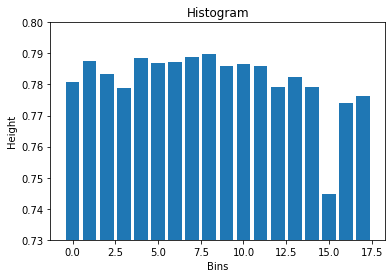

<Figure size 432x288 with 0 Axes>

In [95]:
print(zmanjsano_data)
x_values = [entry[0] for entry in zmanjsano_data]
y_values = [entry[1] for entry in zmanjsano_data]
y2_values = [entry[2] for entry in zmanjsano_data]

plt.bar(x_values, y_values)
plt.xlabel('Bins')
plt.ylabel('Height')
plt.ylim([0.73, 0.8])
plt.title('Histogram')
plt.show()
plt.clf()

# plt.bar(x_values, y2_values)
# plt.xlabel('Bins')
# plt.ylabel('Height')
# plt.title('Histogram')
# plt.show()

In [96]:
nepoch = 3
    # Training progress and eval results are shown as logging.INFO; so enables it.

#needs to be done once if the h5 files need to be recreated...
#dh.download_and_make_data()

hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))


zmanjsano_data2 = []
for i in range(18):
    print("stolpec:", i)
    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_trn_new = pd.DataFrame(np.array(x_trn)[:,i])
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_train_new = pd.DataFrame(np.array(x_train)[:,i])
    x_test_new = pd.DataFrame(np.array(x_test)[:,i])
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
    x_val_new = pd.DataFrame(np.array(x_val)[:,i])

    #print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    #plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train_new.to_numpy(),y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test_new.to_numpy(),y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train_new.shape[0]/BATCH_SIZE)
    test_steps=int(x_test_new.shape[0]/BATCH_SIZE)
    #print("Steps train:{} and test:{}".format(train_steps,test_steps))

    # build a model - a DNN in TF 2.0
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=1, activation='relu'))
    dnn.add(Dense(50, input_dim=1, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    # earlystop_callback = EarlyStopping(
    #         mode='max',
    #         monitor='val_' + eval_metric,
    #         patience=5,
    #         min_delta=0.00001,
    #         verbose=1
    #     )

    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val_new.to_numpy())[:,0]
    #plotting.plot_roc(y_val,y_score)
    #plotting.plot_score(y_val,y_score)
    print()
    auc=roc_auc_score(y_val,y_score)
    loss = dnn.evaluate(x_val_new.to_numpy(), y_val.to_numpy())
    zmanjsano_data2.append([i, auc, loss[-1]])
    print("AUC score: {}".format(auc))


Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
stolpec: 0
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5381 - loss: 0.6886 - val_accuracy: 0.5424 - val_loss: 0.6869
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5422 - loss: 0.6870 - val_accuracy: 0.5444 - val_loss: 0.6866
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5430 - loss: 0.6867 - val_accuracy: 0.5449 - val_loss: 0.6866
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 881us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 902us/step - accuracy: 0.5393 - loss: 0.6876
AUC score: 0.5408646288842408
stolpec: 1
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5264 - loss: 0.6919 - val_accuracy: 0.5299 - val_loss: 0.6911
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5294 - loss: 0.6914 - val_accuracy: 0.5301 - val_loss: 0.6911
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5297 - loss: 0.6914 - val_accuracy: 0.5310 - val_loss: 0.6911
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 883us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 916us/step - accuracy: 0.5271 - loss: 0.6916
AUC score: 0.5116645680111591
stolpec: 2
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5443 - loss: 0.6872 - val_accuracy: 0.5520 - val_loss: 0.6850
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5503 - loss: 0.6852 - val_accuracy: 0.5520 - val_loss: 0.6850
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5503 - loss: 0.6851 - val_accuracy: 0.5519 - val_loss: 0.6850
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 902us/step - accuracy: 0.5494 - loss: 0.6858
AUC score: 0.5442769679801215
stolpec: 3
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5395 - loss: 0.6896 - val_accuracy: 0.5440 - val_loss: 0.6885
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5428 - loss: 0.6887 - val_accuracy: 0.5437 - val_loss: 0.6882
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5430 - loss: 0.6886 - val_accuracy: 0.5436 - val_loss: 0.6881
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 958us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step - accuracy: 0.5472 - loss: 0.6881
AUC score: 0.5496981458202328
stolpec: 4
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5267 - loss: 0.6919 - val_accuracy: 0.5235 - val_loss: 0.6921
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5278 - loss: 0.6916 - val_accuracy: 0.5235 - val_loss: 0.6921
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5279 - loss: 0.6916 - val_accuracy: 0.5235 - val_loss: 0.6921
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.5260 - loss: 0.6919
AUC score: 0.5107050877222656
stolpec: 5
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5249 - loss: 0.6919 - val_accuracy: 0.5265 - val_loss: 0.6912
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5286 - loss: 0.6912 - val_accuracy: 0.5265 - val_loss: 0.6912
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5286 - loss: 0.6912 - val_accuracy: 0.5265 - val_loss: 0.6912
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 905us/step - accuracy: 0.5260 - loss: 0.6911
AUC score: 0.5213046178017497
stolpec: 6
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5263 - loss: 0.6918 - val_accuracy: 0.5296 - val_loss: 0.6910
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5273 - loss: 0.6915 - val_accuracy: 0.5290 - val_loss: 0.6910
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5269 - loss: 0.6914 - val_accuracy: 0.5287 - val_loss: 0.6910
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 867us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.5255 - loss: 0.6915
AUC score: 0.5148129114641498
stolpec: 7
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_159 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5239 - loss: 0.6920 - val_accuracy: 0.5292 - val_loss: 0.6914
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5288 - loss: 0.6915 - val_accuracy: 0.5292 - val_loss: 0.6913
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5288 - loss: 0.6914 - val_accuracy: 0.5292 - val_loss: 0.6913
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - accuracy: 0.5260 - loss: 0.6917
AUC score: 0.5103514541076284
stolpec: 8
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5277 - loss: 0.6917 - val_accuracy: 0.5274 - val_loss: 0.6914
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5290 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5290 - loss: 0.6912 - val_accuracy: 0.5274 - val_loss: 0.6914
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 909us/step - accuracy: 0.5244 - loss: 0.6919
AUC score: 0.5104338583462049
stolpec: 9
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5254 - loss: 0.6912 - val_accuracy: 0.5313 - val_loss: 0.6906
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5271 - loss: 0.6909 - val_accuracy: 0.5313 - val_loss: 0.6905
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5272 - loss: 0.6909 - val_accuracy: 0.5313 - val_loss: 0.6905
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step - accuracy: 0.5260 - loss: 0.6907
AUC score: 0.5255754623060429
stolpec: 10
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5288 - loss: 0.6916 - val_accuracy: 0.5328 - val_loss: 0.6907
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5300 - loss: 0.6909 - val_accuracy: 0.5326 - val_loss: 0.6907
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5299 - loss: 0.6909 - val_accuracy: 0.5336 - val_loss: 0.6906
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 859us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 929us/step - accuracy: 0.5274 - loss: 0.6910
AUC score: 0.5217022397540191
stolpec: 11
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5266 - loss: 0.6918 - val_accuracy: 0.5266 - val_loss: 0.6917
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5282 - loss: 0.6915 - val_accuracy: 0.5266 - val_loss: 0.6916
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5283 - loss: 0.6914 - val_accuracy: 0.5266 - val_loss: 0.6916
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.5260 - loss: 0.6916
AUC score: 0.5151418216801766
stolpec: 12
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_174 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5560 - loss: 0.6836 - val_accuracy: 0.5750 - val_loss: 0.6794
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5778 - loss: 0.6771 - val_accuracy: 0.5751 - val_loss: 0.6791
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5780 - loss: 0.6769 - val_accuracy: 0.5749 - val_loss: 0.6790
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 874us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.5744 - loss: 0.6786
AUC score: 0.5964171203019418
stolpec: 13
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5282 - loss: 0.6921 - val_accuracy: 0.5299 - val_loss: 0.6913
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5282 - loss: 0.6915 - val_accuracy: 0.5299 - val_loss: 0.6913
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5282 - loss: 0.6915 - val_accuracy: 0.5299 - val_loss: 0.6913
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 863us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step - accuracy: 0.5260 - loss: 0.6917
AUC score: 0.5067617776822554
stolpec: 14
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5408 - loss: 0.6869 - val_accuracy: 0.5686 - val_loss: 0.6810
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5640 - loss: 0.6825 - val_accuracy: 0.5681 - val_loss: 0.6809
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5638 - loss: 0.6824 - val_accuracy: 0.5684 - val_loss: 0.6809
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 905us/step - accuracy: 0.5622 - loss: 0.6830
AUC score: 0.5756018407002897
stolpec: 15
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_183 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6200 - loss: 0.6585 - val_accuracy: 0.6328 - val_loss: 0.6452
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6347 - loss: 0.6441 - val_accuracy: 0.6342 - val_loss: 0.6447
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6348 - loss: 0.6436 - val_accuracy: 0.6344 - val_loss: 0.6445
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 821us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step - accuracy: 0.6325 - loss: 0.6450
AUC score: 0.6719883455093303
stolpec: 16
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_186 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5702 - loss: 0.6807 - val_accuracy: 0.5860 - val_loss: 0.6750
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5846 - loss: 0.6740 - val_accuracy: 0.5859 - val_loss: 0.6747
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5856 - loss: 0.6736 - val_accuracy: 0.5861 - val_loss: 0.6745
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 868us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 906us/step - accuracy: 0.5850 - loss: 0.6740
AUC score: 0.6089595463506623
stolpec: 17
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5800 - loss: 0.6797 - val_accuracy: 0.5872 - val_loss: 0.6719
Epoch 2/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5842 - loss: 0.6731 - val_accuracy: 0.5870 - val_loss: 0.6717
Epoch 3/3
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5844 - loss: 0.6729 - val_accuracy: 0.5872 - val_loss: 0.6716
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 829us/step

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step - accuracy: 0.5841 - loss: 0.6729
AUC score: 0.6107954091954116


[[0, 0.5408646288842408, 0.5416300296783447], [1, 0.5116645680111591, 0.5289999842643738], [2, 0.5442769679801215, 0.5515000224113464], [3, 0.5496981458202328, 0.5466899871826172], [4, 0.5107050877222656, 0.5287600159645081], [5, 0.5213046178017497, 0.5287600159645081], [6, 0.5148129114641498, 0.5279800295829773], [7, 0.5103514541076284, 0.5287600159645081], [8, 0.5104338583462049, 0.5275499820709229], [9, 0.5255754623060429, 0.5287600159645081], [10, 0.5217022397540191, 0.5284500122070312], [11, 0.5151418216801766, 0.5287600159645081], [12, 0.5964171203019418, 0.5766299962997437], [13, 0.5067617776822554, 0.5287600159645081], [14, 0.5756018407002897, 0.5641499757766724], [15, 0.6719883455093303, 0.6327800154685974], [16, 0.6089595463506623, 0.5860700011253357], [17, 0.6107954091954116, 0.5827800035476685]]


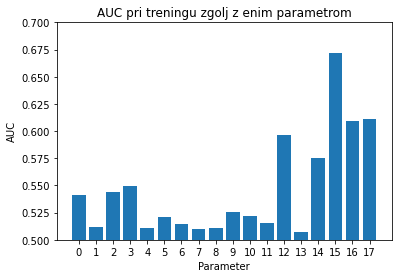

<Figure size 432x288 with 0 Axes>

In [103]:
print(zmanjsano_data2)
x_values = [entry[0] for entry in zmanjsano_data2]
y_values = [entry[1] for entry in zmanjsano_data2]
#y2_values = [entry[2] for entry in zmanjsano_data2]

plt.bar(x_values, y_values)
plt.xlabel('Parameter')
plt.ylabel('AUC')
#plt.ylim([0.73, 0.8])
plt.ylim([0.5, 0.7])
plt.xticks(x_values)
plt.title('AUC pri treningu zgolj z enim parametrom')
#plt.savefig("en_par.png")
plt.show()
plt.clf()

Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
Steps train:3600 and test:400
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6026 - loss: 0.6548 - val_accuracy: 0.6574 - val_loss: 0.6154
Epoch 2/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6621 - loss: 0.6120 - val_accuracy: 0.6787 - val_loss: 0.5961
Epoch 3/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6786 - loss: 0.5958 - val_accuracy: 0.6902 - val_loss: 0.5841
Epoch 4/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6888 - loss: 0.5853 - val_accuracy: 0.6973 - val_loss: 0.5758
Epoch 5/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6948 - loss: 0.5774 - val_accuracy: 0.7017 - val_loss: 0.5697
Epoch 6/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6991 - loss: 0.5719 - val_accuracy: 0.7060 - val_loss: 0.5658
Epoch 7/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7033 - loss: 0.5678 - val_accuracy: 0.7073 - val_loss: 0.5633
Epoch 8/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7061 - loss: 0.5642 - 

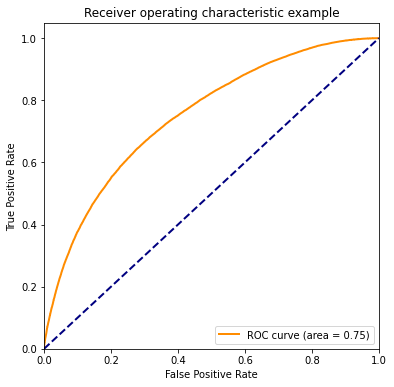

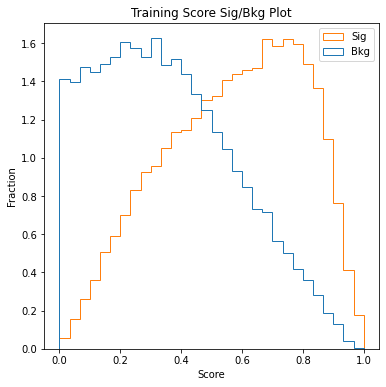

In [49]:
main(10)

In [61]:
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))



# ready the data for TF
ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

train_steps=int(x_train.shape[0]/BATCH_SIZE)
test_steps=int(x_test.shape[0]/BATCH_SIZE)
print("Steps train:{} and test:{}".format(train_steps,test_steps))

# build a model - a DNN in TF 2.0
dnn = Sequential()
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(1, activation='sigmoid')) # output layer/value
plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])

dnn.summary()

#optional early stopping
eval_metric = 'AUC'


#NaKratko .... !
ROC_data_N = []
time_data_N = []
loss_data_N = []

for i in range(1, 11):
    nepoch = i
    print(nepoch)
    start = time.time()
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    # plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='auc')
    # plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')
    #plotting.plot_history([('DNN model', dnn_model_history),])
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc=roc_auc_score(y_val,y_score)
    ROC_data_N.append(auc)
    loss = dnn.evaluate(x_val.to_numpy(), y_val.to_numpy())
    loss_data_N.append(loss)
    
    end = time.time()
    time_data_N.append([nepoch, end - start])

    


Loading d:\Ziga\Documents\FMF\3. letnik\1. semester\Matematično-fizikalni praktikum\DN\12\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)
Steps train:3600 and test:400
You must install pydot (`pip install pydot`) for `plot_model` to work.


d:\Program Files\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

1
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5988 - loss: 0.6561 - val_accuracy: 0.6571 - val_loss: 0.6187
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.6443 - loss: 0.6325
2
Epoch 1/2
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6579 - loss: 0.6157 - val_accuracy: 0.6883 - val_loss: 0.5893
Epoch 2/2
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6806 - loss: 0.5939 - val_accuracy: 0.6966 - val_loss: 0.5774
history values dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 856us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.6798 - loss: 0.5949
3
Epoch 1/3
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6896 - loss: 0.5830 - val_accuracy: 0.7036 - val_loss: 0.5694
Epoch 2/3
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6961 - loss: 0.5754 - v

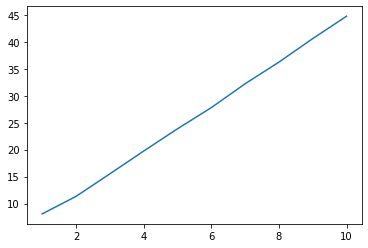

In [58]:
#print(np.array(time_data)[:,0])
#plt.plot(np.array(time_data)[:,0], np.array(time_data)[:,1])
plt.plot(np.array(time_data_N)[:,0], np.array(time_data_N)[:,1])

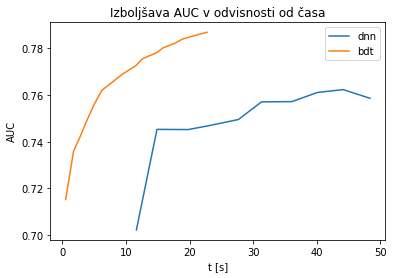

In [90]:
plt.plot(np.array(time_data_N)[:,1], np.array(ROC_data_N), label="dnn")
plt.plot(np.array(time_data)[:,1], np.array(AOC_data), label="bdt")
plt.xlabel('t [s]')
plt.ylabel('AUC')
plt.title('Izboljšava AUC v odvisnosti od časa')
plt.legend()
#plt.savefig("casi_obe.png")